# Classifying Glass with Gradient Boosting

In [1]:
from math import sqrt, fabs, exp
import matplotlib.pyplot as plt
from sklearn.linear_model import enet_path
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
import numpy as np
import seaborn as sns

sns.set()

In [2]:
# arrange data into list for labels and list of lists for attributes
x_list = []
data_path = './data/glass.data'

with open(data_path) as data:
    
    for line in data:
        # split on comma
        row = line.strip().split(',')
        x_list.append(row)
        
glass_names = np.array(['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type'])

# Separate attributes and labels
x_num = []
labels = []

for row in x_list:
    labels.append(row.pop())
    l = len(row)
    # eliminate ID
    attr_row = [float(row[i]) for i in range(1, l)]
    x_num.append(attr_row)
    
# number of rows and columns in x matrix
n_rows = len(x_num)
n_cols = len(x_num[1])

# Labels are integers from 1 to 7 with no examples of 4
# gb requires consecutive integers starting at 0
new_labels = []
label_set = set(labels)
label_list = list(label_set)
label_list.sort()
n_labels = len(label_list)

for l in labels:
    index = label_list.index(l)
    new_labels.append(index)

In [3]:
# startified sampling by labels
x_temp = [x_num[i] for i in range(n_rows) if new_labels[i] == 0]
y_temp = [new_labels[i] for i in range(n_rows) if new_labels[i] == 0]
x_train, x_test, y_train, y_test = train_test_split(x_temp, y_temp, test_size=0.30, random_state=531)

for i_label in range(1, len(label_list)):
    # segregate x and y according to labels
    x_temp = [x_num[i] for i in range(n_rows) if new_labels[i] == i_label]
    y_temp = [new_labels[i] for i in range(n_rows) if new_labels[i] == i_label]
    
    # form train and test sets on segregated subset of examples
    x_train_temp, x_test_temp, y_train_temp, y_test_temp = train_test_split(x_temp, y_temp, test_size=0.030,
                                                                           random_state=531)
    
    # accumulate
    x_train = np.append(x_train, x_train_temp, axis=0)
    x_test = np.append(x_test, x_test_temp, axis=0)
    y_train = np.append(y_train, y_train_temp, axis=0)
    y_test = np.append(y_test, y_test_temp, axis=0)

In [4]:
# instantiate model
n_est = 500
depth = 3
learn_rate = 0.003
max_features = 3
sub_samp = 0.5
glass_gbm_model = ensemble.GradientBoostingClassifier(n_estimators=n_est, max_depth=depth, learning_rate=learn_rate,
                                                     max_features=max_features, subsample=sub_samp)

# train
glass_gbm_model.fit(x_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.003, loss='deviance', max_depth=3,
              max_features=3, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)

In [5]:
# compute auc on test set as function of ensemble size
misclass_error = []
misclass_best = 1.0
predictions = glass_gbm_model.staged_decision_function(x_test)

for p in predictions:
    misclass = 0
    
    for i in range(len(p)):
        list_p = p[i].tolist()
        
        if list_p.index(max(list_p)) != y_test[i]:
            misclass += 1
            
    misclass = float(misclass)/len(p)
    misclass_error.append(misclass)
    
    # capture best predictions
    if misclass < misclass_best:
        misclass_best = misclass
        p_best = p
        
idx_best = misclass_error.index(min(misclass_error))

In [6]:
# print best values
print(f'Best Misclassification Error: {misclass_best}')
print(f'Number of Trees for Best Misclassification Error: {idx_best}')

Best Misclassification Error: 0.25
Number of Trees for Best Misclassification Error: 145


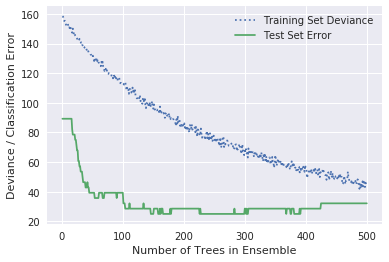

In [7]:
# plot training deviance and test AUCs vs number of trees in ensemble
misclass_error = [100 * mce for mce in misclass_error]
plt.figure()
plt.plot(range(1, n_est + 1), glass_gbm_model.train_score_, label='Training Set Deviance', linestyle=':')
plt.plot(range(1, n_est + 1), misclass_error, label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Deviance / Classification Error')
plt.show()

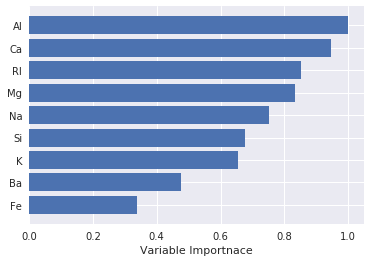

In [8]:
# Plot feature importance
feature_importance = glass_gbm_model.feature_importances_

# normalize by max importance
feature_importance = feature_importance/feature_importance.max()

# plot variable importance
idx_sorted = np.argsort(feature_importance)
bar_pos = np.arange(idx_sorted.shape[0]) + 0.5
plt.barh(bar_pos, feature_importance[idx_sorted], align='center')
plt.yticks(bar_pos, glass_names[idx_sorted])
plt.xlabel('Variable Importnace')
plt.show()

In [9]:
# generate confusion matrix for best prediction
p_best_list = p_best.tolist()
best_prediction = [r.index(max(r)) for r in p_best_list]
confusion_mat = confusion_matrix(y_test, best_prediction)
print(f'Confusion Matrix:\n\n {confusion_mat}')

Confusion Matrix:

 [[18  3  0  0  0  0]
 [ 2  1  0  0  0  0]
 [ 0  1  0  0  0  0]
 [ 0  1  0  0  0  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  0  0  1]]
